# Node representation learning with Deep Graph Infomax and HinSAGE


This demo demonstrates how to perform unsupervised training of a GCN, GAT, APPNP, or GraphSAGE model using the Deep Graph Infomax algorithm (https://arxiv.org/pdf/1809.10341.pdf) on the GM12878_sample dataset. 

As with all StellarGraph workflows: first we load the dataset, next we create our data generators, and then we train our model. We then take the embeddings created through unsupervised training and predict the node classes using logistic regression.

In [1]:
from stellargraph.mapper import (
    CorruptedGenerator,
    FullBatchNodeGenerator,
    GraphSAGENodeGenerator,
    HinSAGENodeGenerator,
)
from stellargraph import StellarDiGraph
from stellargraph.layer import GCN, DeepGraphInfomax, GraphSAGE, GAT, APPNP, HinSAGE

from stellargraph import datasets
from stellargraph.utils import plot_history

import pandas as pd
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from IPython.display import display, HTML

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import Model
if tf.test.gpu_device_name():
  print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

from pathlib import Path

Default GPU Device:/device:GPU:0


(See [the "Loading from Pandas" demo](../basics/loading-pandas.ipynb) for details on how data can be loaded.)

## Load graph and node features

In [2]:
DATA_FOLDER = Path("../../data/")
FEATURE_FOLDER = Path('../../data/features/')
FILE_NAME = 'joint_renamed.csv'
FEATURE_FILE = 'joint_renamed_onehot_names.csv'
SEP = ','

df = pd.read_csv(DATA_FOLDER / FILE_NAME, sep=SEP)[['cell_type', 'source', 'target', 'weight', 'type']]

feature_df = pd.read_csv(FEATURE_FOLDER / FEATURE_FILE, index_col=0)



In [3]:
df['edge_type'] = df['type'].map(lambda x: 1 if x == 'TSS' else 0)


G = StellarDiGraph(edges=df[['source', 'target', 'edge_type']], edge_type_column='edge_type', nodes=feature_df)
print(G.info())

StellarDiGraph: Directed multigraph
 Nodes: 8829, Edges: 46680

 Node types:
  default: [8829]
    Features: float32 vector, length 8829
    Edge types: default-0->default, default-1->default

 Edge types:
    default-0->default: [42076]
        Weights: all 1 (default)
        Features: none
    default-1->default: [4604]
        Weights: all 1 (default)
        Features: none


In [29]:
'ATF3_gm' in G.nodes()

True

## Data Generators

Now we create the data generators using `CorruptedGenerator`. `CorruptedGenerator` returns shuffled node features along with the regular node features and we train our model to discriminate between the two. 

Note that:

- We typically pass all nodes to `corrupted_generator.flow` because this is an unsupervised task
- We don't pass `targets` to `corrupted_generator.flow` because these are binary labels (true nodes, false nodes) that are created by `CorruptedGenerator`

In [4]:
# HinSAGE model 
hinsage_generator = HinSAGENodeGenerator(
    G, batch_size=50, num_samples=[10, 10]
)

hinsage_model = HinSAGE(
    layer_sizes=[64, 64], activations=["linear", "relu"], generator=hinsage_generator
)
# hinsage_acc = run_deep_graph_infomax(hinsage_model, hinsage_generator, epochs=epochs)

# print(f"Test classification accuracy: {hinsage_acc}")

corrupted_generator = CorruptedGenerator(hinsage_generator)
gen = corrupted_generator.flow(G.nodes())

## Model Creation and Training

We create and train our `DeepGraphInfomax` model. Note that the loss used here must always be `tf.nn.sigmoid_cross_entropy_with_logits`.

In [5]:
infomax = DeepGraphInfomax(hinsage_model, corrupted_generator)
x_in, x_out = infomax.in_out_tensors()

model = Model(inputs=x_in, outputs=x_out)
model.compile(loss=tf.nn.sigmoid_cross_entropy_with_logits, 
              optimizer=Adam(lr=1e-3),
#               metrics=['loss']
              )

In [6]:
epochs = 100

In [7]:
# # checkpoint (Not working here)
# filepath="./checkpoints/weights-improvement-{epoch:02d}-{loss:.2f}.hdf5"
# cp = tf.keras.callbacks.ModelCheckpoint(str(filepath), 
#                              monitor='loss', 
#                              verbose=0, 
#                              save_best_only=True, 
#                              save_weights_only=True,
#                              mode='auto')


In [8]:
es = EarlyStopping(monitor="loss", min_delta=0, patience=20)

history = model.fit(gen, epochs=epochs, verbose=1, callbacks=[es])


  ...
    to  
  ['...']
Train for 177 steps
Epoch 1/100
177/177 [==============================] - 194s 1s/step - loss: 0.0975
Epoch 2/100
177/177 [==============================] - 197s 1s/step - loss: 0.0016
Epoch 3/100
177/177 [==============================] - 194s 1s/step - loss: 5.7751e-04
Epoch 4/100
177/177 [==============================] - 196s 1s/step - loss: 3.1084e-04
Epoch 5/100
177/177 [==============================] - 195s 1s/step - loss: 1.8799e-04
Epoch 6/100
177/177 [==============================] - 194s 1s/step - loss: 1.5307e-04
Epoch 7/100
177/177 [==============================] - 194s 1s/step - loss: 9.7489e-05
Epoch 8/100
177/177 [==============================] - 195s 1s/step - loss: 8.3846e-05
Epoch 9/100
177/177 [==============================] - 194s 1s/step - loss: 7.4434e-05
Epoch 10/100
177/177 [==============================] - 193s 1s/step - loss: 5.5026e-05
Epoch 11/100
177/177 [==============================] - 194s 1s/step - loss: 5.1825e-05
Epoc

In [9]:
model_name='joint_[64,64]_[linear,relu]_[10,10]'
model.save(f'./cps/{model_name}.h5')

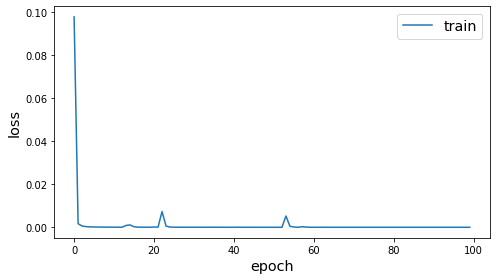

In [10]:
plot_history(history)

## Extracting Embeddings

Since we've already trained the weights of our base model - HinSAGE in this example - we can simply use `base_model.in_out_tensors` to obtain the trained node embedding model. 

In [11]:
x_emb_in, x_emb_out = hinsage_model.in_out_tensors()

# for full batch models, squeeze out the batch dim (which is 1)
# x_out = tf.squeeze(x_emb_out, axis=0)
# emb_model = Model(inputs=x_emb_in, outputs=x_out)

# not using full batch models
emb_model = Model(inputs=x_emb_in, outputs=x_emb_out)

## Visualisation with TSNE

Here we visualize the node embeddings with TSNE. As you can see below, the Deep Graph Infomax model produces well separated embeddings using unsupervised training.

In [12]:
all_embeddings = emb_model.predict(hinsage_generator.flow(G.nodes()))

# y = node_subjects.astype("category")
trans = TSNE(n_components=2)
emb_transformed = pd.DataFrame(trans.fit_transform(all_embeddings), index=G.nodes())
# emb_transformed["label"] = y

In [46]:
tf2gene = df[df['type'] == 'TSS']
tfs = set(tf2gene['source'])
print(tfs)

def geneType(name):
    if name in tfs:
        if name[-2:] == '_k':
            return 1
        elif name[-3:] == '_gm':
            return 2
    else:
        return 0

emb_transformed['type'] = emb_transformed.index.map(geneType)

{'CHD2_k', 'ETV6_gm', 'SMAD5_gm', 'TARDBP_k', 'ZBED1_gm', 'POLR2A_gm', 'ZBTB33_gm', 'SIN3A_gm', 'MTA2_gm', 'SP1_gm', 'ETS1_gm', 'HDGF_k', 'TAF1_k', 'CEBPZ_gm', 'GABPA_gm', 'EGR1_gm', 'TBP_gm', 'POLR2A_k', 'JUNB_k', 'MAZ_gm', 'NFE2_k', 'USF1_k', 'UBTF_gm', 'RAD21_k', 'ZNF274_k', 'JUND_gm', 'REST_k', 'SIN3A_k', 'POLR2AphosphoS2_k', 'SUZ12_k', 'MXI1_gm', 'JUNB_gm', 'ZBED1_k', 'ETV6_k', 'YBX1_k', 'GABPA_k', 'EP300_gm', 'FOS_k', 'POLR2AphosphoS2_gm', 'MXI1_k', 'ELK1_k', 'ZNF143_k', 'RFX5_gm', 'BCLAF1_k', 'NFYB_gm', 'SIX5_k', 'CHD1_k', 'IKZF1_k', 'NBN_k', 'PML_gm', 'MYC_gm', 'NFYB_k', 'ZNF143_gm', 'MEF2A_gm', 'CBX5_k', 'NR2C2_gm', 'MAX_gm', 'YY1_gm', 'MTA2_k', 'SUZ12_gm', 'MAFK_gm', 'STAT5A_gm', 'TARDBP_gm', 'SMC3_k', 'MAZ_k', 'NR2C2_k', 'SPI1_gm', 'CHD1_gm', 'STAT5A_k', 'TBL1XR1_k', 'CTCF_k', 'POLR2AphosphoS5_k', 'E2F4_gm', 'ATF3_gm', 'MYC_k', 'MAX_k', 'CTCF_gm', 'HDGF_gm', 'CEBPB_k', 'SRF_gm', 'USF1_gm', 'ELF1_k', 'BHLHE40_gm', 'YY1_k', 'BCLAF1_gm', 'POLR2AphosphoS5_gm', 'ATF3_k', 'RCOR1_k

In [47]:
emb = pd.DataFrame(all_embeddings, index=G.nodes())
emb['type'] = emb.index.map(geneType)
emb[emb.index == 'ATF3_gm']
emb.to_csv(f'./emb/{model_name}.csv', index=True, header=True)

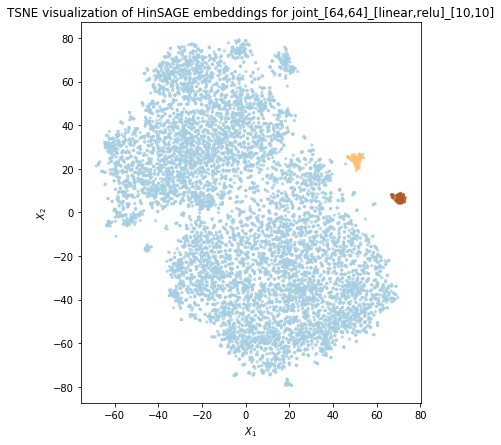

In [48]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["type"],
    cmap="Paired",
    alpha=alpha,
    s=5
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(f"TSNE visualization of HinSAGE embeddings for {model_name}")

plt.savefig(f'./img/{model_name}.png', dpi=150)
plt.show()

